### 0. Load Data and import Libraries

Первым делом подключим необхождимые библиотеки и загрузим датасеты

In [641]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from datetime import datetime
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

df_train = pd.read_csv("/content/drive/MyDrive/Учеба/ PyColab/Lineral_Regression/train.csv", parse_dates=['ApplicationDate'])
df_test  = pd.read_csv("/content/drive/MyDrive/Учеба/ PyColab/Lineral_Regression/test.csv", parse_dates=['ApplicationDate'])


### 1. Check and clean DataFrame

Изучим типы данных в столбцах, количесвто столбцов и строк

In [642]:
print("Size = ", df_train.shape)
print("Columns typs:")
print(df_train.dtypes)

Size =  (11017, 36)
Columns typs:
ApplicationDate               datetime64[ns]
Age                                  float64
AnnualIncome                         float64
CreditScore                          float64
LoanAmount                           float64
LoanDuration                         float64
MaritalStatus                         object
NumberOfDependents                   float64
HomeOwnershipStatus                   object
MonthlyDebtPayments                  float64
CreditCardUtilizationRate            float64
NumberOfOpenCreditLines              float64
NumberOfCreditInquiries              float64
DebtToIncomeRatio                    float64
BankruptcyHistory                    float64
LoanPurpose                           object
PreviousLoanDefaults                 float64
PaymentHistory                       float64
LengthOfCreditHistory                float64
SavingsAccountBalance                float64
CheckingAccountBalance               float64
TotalAssets          

Как можно заметить, у нас есть столбцы со значениями "object". Линейные модели с ними не умеют, поэтому исправим это с помощью дискретизации признаков, используя one-hot-encodig. Т.к. столбцов, имеющих значение > 1 напишем функцию для дискретизации признаков и добавления новых столбцов в датафрейм и удалим начальные
столбцы.

In [643]:
def ohe(data):
    obj_columns = list(data.select_dtypes(include='object').columns)
    print(obj_columns)
    new_columns = []
    for column in obj_columns:
        column_val = data[column].unique() #Берем все уникальные значения, которые есть в каждом столбце с типом 'object'
        for val in column_val:
            if str(val) =="nan": #У нас в датасете есть величины со значением NaN, создавать отдельный стобец для них мы не собираемся, поэтому пропускаем
                continue
            data[column+"_"+val]=pd.Series(data[column] ==val, dtype=float)
            new_columns.append(column+"_"+val)
    return data.drop(columns = obj_columns), new_columns

Вызовем самописную функцию one-hot-encoding. Проверим текущий размер датафрейма.

In [644]:
df_train, ohe_col  = ohe(df_train)
# df_train = df_train.dropna()
print(ohe_col)
print("Size = ", df_train.shape) # Как видим столбцов добавилось прилично

['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']
['MaritalStatus_Divorced', 'MaritalStatus_Widowed', 'MaritalStatus_Married', 'MaritalStatus_Single', 'HomeOwnershipStatus_Rent', 'HomeOwnershipStatus_Mortgage', 'HomeOwnershipStatus_Other', 'HomeOwnershipStatus_Own', 'LoanPurpose_Education', 'LoanPurpose_Home', 'LoanPurpose_Debt Consolidation', 'LoanPurpose_Auto', 'LoanPurpose_Other', 'EmploymentStatus_Employed', 'EmploymentStatus_Self-Employed', 'EmploymentStatus_Unemployed', 'EducationLevel_Associate', 'EducationLevel_High School', 'EducationLevel_Bachelor', 'EducationLevel_Master', 'EducationLevel_Doctorate']
Size =  (11017, 52)


Кроме того, у нас осталась колонка 'ApplicationDate' с типом данных datetime. Работать с ним линейная модель тоже не умеет. Соответсвенно мы должны избавиться от неё в текущем её виде. Для начала попробуем извлечь из нее хоть какую-то пользу. Для это возьмем из даты только год и вычтем из него текущий год (я изхожу из того, что модель может использоваться на более свежих даных, поэтому наилучшый способ добавить зависимость от этого признака оставить количество лет, прошедших с подачи заявления). Получившейся столбец назовем 'Years_cnt'.

В дальнейшем изучим значения модели с этим столбцом и без него, и тогда решим, оставлять его, либо вообще убрать т.к. портит метрики.

Но это потом, а сейчас выведем оставшиеся столбцы с описанием их типов.

In [645]:
cur_year = datetime.now().year
df_train['Years_cnt'] =pd.Series(cur_year - df_train['ApplicationDate'].dt.year, dtype=float)
df_train = df_train.drop(columns= 'ApplicationDate')
print("Columns typs:")
print(df_train.dtypes)

Columns typs:
Age                               float64
AnnualIncome                      float64
CreditScore                       float64
LoanAmount                        float64
LoanDuration                      float64
NumberOfDependents                float64
MonthlyDebtPayments               float64
CreditCardUtilizationRate         float64
NumberOfOpenCreditLines           float64
NumberOfCreditInquiries           float64
DebtToIncomeRatio                 float64
BankruptcyHistory                 float64
PreviousLoanDefaults              float64
PaymentHistory                    float64
LengthOfCreditHistory             float64
SavingsAccountBalance             float64
CheckingAccountBalance            float64
TotalAssets                       float64
TotalLiabilities                  float64
MonthlyIncome                     float64
UtilityBillsPaymentHistory        float64
JobTenure                         float64
Experience                        float64
NetWorth            

Избавимся от строк-дупбикатов, если такие имеются и сразу проверим актуальный размер датафрейма.

In [646]:
df_train = df_train.drop_duplicates()
print("Size = ", df_train.shape) # Продуктивно покосили дупликаты
# print(df_train.iloc[5])

Size =  (10001, 52)


Проверим наш датафрейм на отсутсвие знаений.

In [647]:
df_train.isnull().sum()

,0
Age,1
AnnualIncome,1
CreditScore,472
LoanAmount,472
LoanDuration,1
NumberOfDependents,1
MonthlyDebtPayments,472
CreditCardUtilizationRate,1
NumberOfOpenCreditLines,1
NumberOfCreditInquiries,1


Как видим, есть несколько столбцов, которые содержат одиновое количсевто пропусков, можно предположить, что такие строки полностью состоят из Nan. Проверим нашу гипотезу, выведя парую таких строчек

In [648]:
null_df = df_train[df_train.isnull()]
print(null_df.iloc[0:7])

   Age  AnnualIncome  CreditScore  LoanAmount  LoanDuration  \
0  NaN           NaN          NaN         NaN           NaN   
1  NaN           NaN          NaN         NaN           NaN   
2  NaN           NaN          NaN         NaN           NaN   
3  NaN           NaN          NaN         NaN           NaN   
4  NaN           NaN          NaN         NaN           NaN   
5  NaN           NaN          NaN         NaN           NaN   
6  NaN           NaN          NaN         NaN           NaN   

   NumberOfDependents  MonthlyDebtPayments  CreditCardUtilizationRate  \
0                 NaN                  NaN                        NaN   
1                 NaN                  NaN                        NaN   
2                 NaN                  NaN                        NaN   
3                 NaN                  NaN                        NaN   
4                 NaN                  NaN                        NaN   
5                 NaN                  NaN               

Как видим, наша гипотеза оказалась верной, поэтому просто избавимся от всех таких строк и посмотрим общее количество оставшихся строк

In [649]:
df_train = df_train.dropna()
df_train.isnull().sum()
print("Size = ", df_train.shape)

Size =  (9529, 52)


Теперь проверим датасет на выбросы. Начнем со столбца "RiskScore"

<Axes: xlabel='RiskScore'>

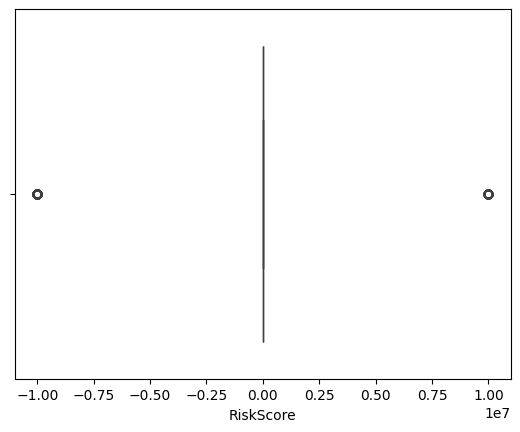

In [650]:
sns.boxplot(x=df_train['RiskScore'])

Видим очевидные выбросы. Попробуем две стратегии:

1) Удалим строчи с выбросами

2) Заменим выбросы на более близкие к выборке значения

Сравним оценку модели в обоих случаях и выберем лучший

New values for deleted target outliers values:
count    9332.000000
mean       48.312511
std        17.243078
min        14.841417
25%        32.693275
50%        44.127496
75%        65.059406
max        97.597249
Name: RiskScore, dtype: float64
New values for changed target outliers values:
count    9.529000e+03
mean    -3.458380e+04
std      1.437496e+06
min     -9.999999e+06
25%      3.249476e+01
50%      4.401980e+01
75%      6.526522e+01
max      1.000000e+07
Name: RiskScore, dtype: float64

Check sizes: 
For changed: 9529
For deleted: 9332


<ipython-input-651-4ec3df512749>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2[(df_train['RiskScore'] > upper_bound) | (df_train['RiskScore'] <lower_bound)]['RiskScore'] = df_train_1['RiskScore'].mean()


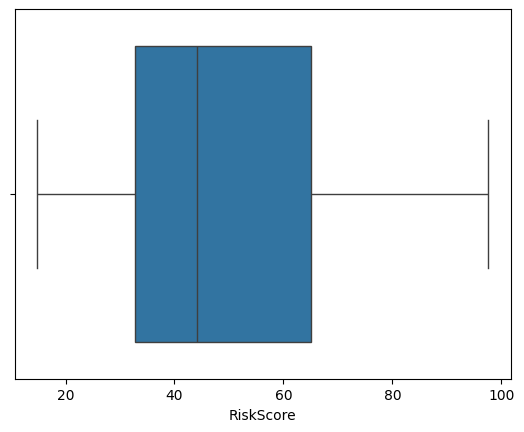

In [651]:
q1 = df_train['RiskScore'].quantile(.15)
q2 = df_train['RiskScore'].quantile(.85)
iqr = q2 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q2 + (1.5 * iqr)

df_train_1 = df_train.drop(index = df_train[(df_train['RiskScore'] > upper_bound) | (df_train['RiskScore'] <lower_bound)].index)
sns.boxplot(x=df_train_1['RiskScore'])

df_train_2 =  df_train.copy()
df_train_2[(df_train['RiskScore'] > upper_bound) | (df_train['RiskScore'] <lower_bound)]['RiskScore'] = df_train_1['RiskScore'].mean()

print("New values for deleted target outliers values:")
print(df_train_1['RiskScore'].describe())
print("New values for changed target outliers values:")
print(df_train_2['RiskScore'].describe())
print()
print("Check sizes: ")
print("For changed:", df_train_2.shape[0])
print("For deleted:", df_train_1.shape[0])

Обучим и сравним значения

In [652]:
def new_model(X, Y, del_columns_list, idx):
    model = LinearRegression()
    for _ in del_columns_list:
      if _ in X:
        X = X.drop(columns = _)

    #Разобъем данные на тестовую и тренировочные выборки
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

    model.fit(X_train.values, Y_train.values)

    y_test = model.predict(X_test.values)
    y_train = model.predict(X_train.values)

    print("Model",idx, "=")
    print("Train RMSE = %.4f" % mean_squared_error(Y_train, y_train, squared=False))
    print("Test RMSE = %.4f" % mean_squared_error(Y_test, y_test, squared=False))
    print()
    return model, X

Y1=df_train_1['RiskScore']
X1=df_train_1.drop(columns=['RiskScore'])

Y2=df_train_2['RiskScore']
X2=df_train_2.drop(columns=['RiskScore'])

model1, X1 = new_model(X1, Y1, ['_'], 1)
model2, X2 = new_model(X2, Y2, ['_'], 2)

Model 1 =
Train RMSE = 4.3878
Test RMSE = 4.3141

Model 2 =
Train RMSE = 1433635.6250
Test RMSE = 1440738.3515



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

Очевидно, выбираем первую модель...

Попробуем закинуть в систему

In [653]:
def test_preparing(df, del_columns):
    new_df, tmpp = ohe(df)
    cur_year = datetime.now().year
    new_df['Years_cnt'] =pd.Series(cur_year - df['ApplicationDate'].dt.year, dtype=int)
    for _ in del_columns:
      if _ in df:
        new_df = new_df.drop(columns = _) # Удаление указанных столбцов
    # new_df = discrete(new_df, ['Age'])
    return new_df

def new_predict(model, df, del_list, idx):
    X_test = test_preparing(df, del_list)
    Terget_predict=pd.DataFrame(X_test['ID'])
    X_test=X_test.drop(columns=['ID'])
    X_test = X_test.astype(float)
    Terget_predict['RiskScore']  = model.predict(X_test.values)
    Terget_predict.to_csv("/content/drive/MyDrive/Учеба/ PyColab/Lineral_Regression/target_"+str(idx)+".csv", index=False)

del_list = ['ApplicationDate']
new_predict(model1, df_test, del_list, 1)
# new_predict(model2, df_test, del_list, 2)


['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']


На данном этапе я закинул полученные значения в тестирующую систему и получил:

1) MSE Model 1 = 19.00

<!-- 2) MSE Model 2 = 18.97 -->

Вторая модель(с сохранеными выбросами/заменнеными на среднее) показывает себя лучше, поэтому пока будем работать с ней, но в дальнейшем будем попробуем те же дейтвия применить и к первому датасету.

In [654]:
X = X1
Y = Y1

### 2.  Check Data Correlation

Первостепенная обработка данных окончена, теперь перейдем к доскональному изучению всех столбцов и проверки их на выбросы, а кроме того проверим их распределение.

Теперь прикинимся, что мы типо крутые аналитики и посмотрим на корреляцию столбца-таргета(Y) и всех признаков, чтобы найти стобцы с сильной линейной связью. Это нужно для первичной оценки стобцов, сильнее или слабее влиящих на предсказываемое значение.

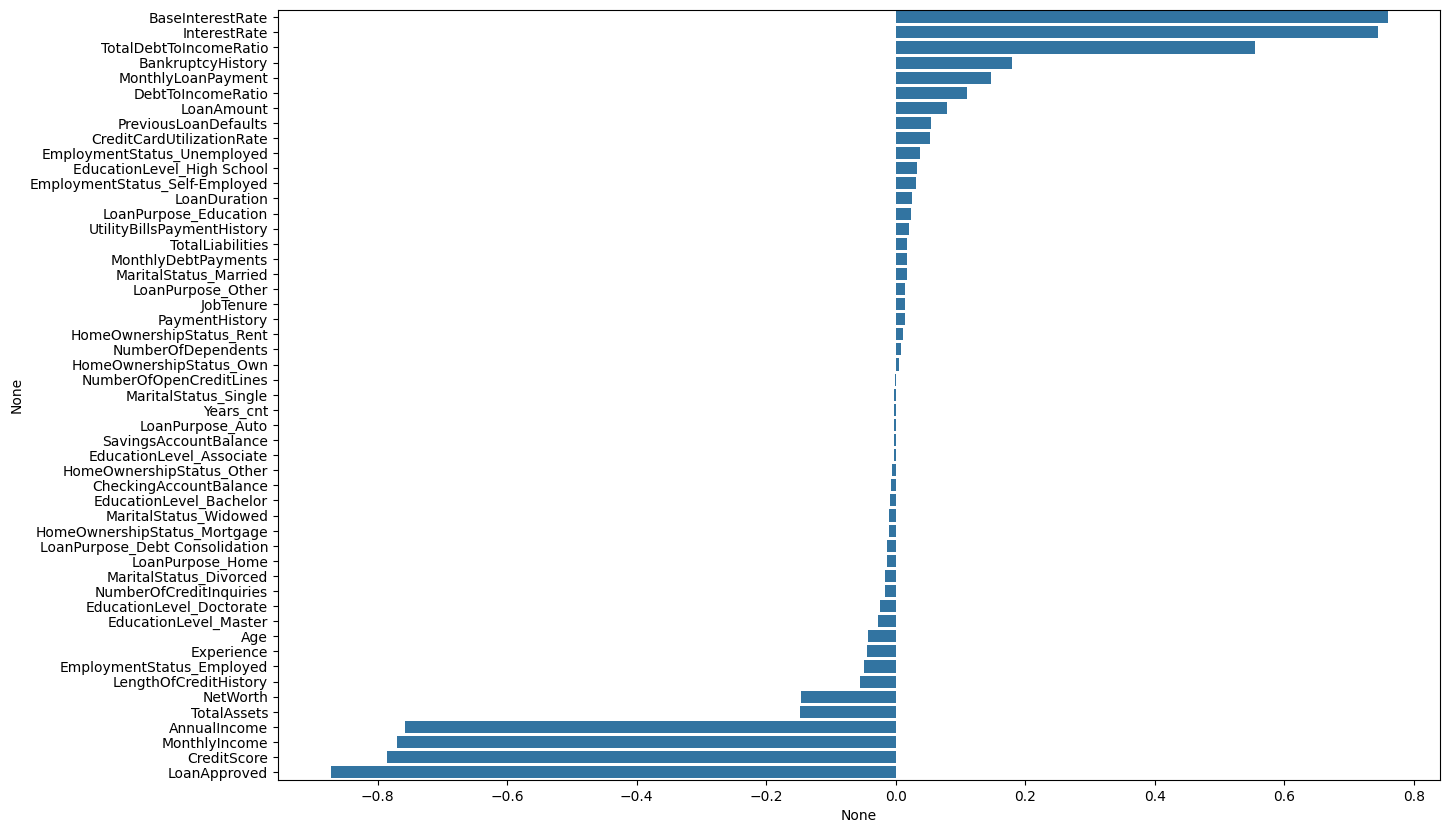

In [655]:
correlations = X.corrwith(Y).sort_values(ascending=False)
plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

В данном случае можно попробовать убрать столбцы с наименьшей корреляцией, т.к. они никак не влияют на обучнеие, но убрать их мы попробуем чуть позже. А сейчас посмотрим коэффициент корреляции между всеми столбцами-принаками, чтобы убрать среди них наиболее линейно-связанные столбцы.

In [656]:
X.corr()

,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,...,LoanPurpose_Other,EmploymentStatus_Employed,EmploymentStatus_Self-Employed,EmploymentStatus_Unemployed,EducationLevel_Associate,EducationLevel_High School,EducationLevel_Bachelor,EducationLevel_Master,EducationLevel_Doctorate,Years_cnt
Age,1.000000,0.038768,0.057672,0.010759,0.020756,0.019047,-0.014398,0.026594,-0.003240,-0.000922,...,0.003684,0.000068,0.003969,-0.005970,0.008194,0.004896,-0.008218,0.002548,-0.014357,0.004137
AnnualIncome,0.038768,1.000000,0.615892,0.008688,-0.016195,-0.003627,0.010525,-0.006447,0.001915,0.015591,...,-0.007348,0.000715,-0.003928,0.004557,-0.002336,-0.044618,0.013731,0.040854,0.033220,-0.000087
CreditScore,0.057672,0.615892,1.000000,0.003493,-0.012691,-0.000592,0.006672,-0.008426,-0.002553,0.006102,...,-0.009775,-0.004509,0.002577,0.003983,0.003877,-0.031476,0.004678,0.029491,0.022953,-0.003360
LoanAmount,0.010759,0.008688,0.003493,1.000000,-0.005901,0.006151,-0.002986,-0.010610,0.003366,-0.003484,...,-0.002479,-0.003494,0.000700,0.004998,-0.000186,-0.002755,0.010271,-0.010861,-0.002460,-0.005204
LoanDuration,0.020756,-0.016195,-0.012691,-0.005901,1.000000,0.007244,0.019149,-0.012862,0.011821,0.005693,...,0.013106,-0.014452,0.013287,0.005349,-0.025248,0.005831,0.002310,0.015498,0.011740,0.000827
NumberOfDependents,0.019047,-0.003627,-0.000592,0.006151,0.007244,1.000000,-0.014537,0.012407,-0.013289,0.004598,...,-0.007759,-0.000033,-0.002837,0.004242,-0.020795,-0.001769,0.013616,0.003024,0.011952,0.005130
MonthlyDebtPayments,-0.014398,0.010525,0.006672,-0.002986,0.019149,-0.014537,1.000000,0.004284,-0.012028,0.026193,...,-0.022147,-0.010466,0.011722,0.000778,-0.009902,0.021159,-0.015404,0.004012,-0.002556,-0.021038
CreditCardUtilizationRate,0.026594,-0.006447,-0.008426,-0.010610,-0.012862,0.012407,0.004284,1.000000,0.004735,0.017103,...,-0.009460,0.013214,-0.013374,-0.003085,0.013604,0.009684,-0.017488,0.000417,-0.012790,-0.021424
NumberOfOpenCreditLines,-0.003240,0.001915,-0.002553,0.003366,0.011821,-0.013289,-0.012028,0.004735,1.000000,0.006664,...,0.003937,0.000582,0.000560,-0.001830,0.006158,-0.006805,0.008134,-0.006675,-0.006072,-0.015930
NumberOfCreditInquiries,-0.000922,0.015591,0.006102,-0.003484,0.005693,0.004598,0.026193,0.017103,0.006664,1.000000,...,-0.000089,-0.001422,0.005116,-0.005089,0.006053,0.006217,-0.006729,-0.015175,0.008643,-0.024009


Такой результат сложновато интерпретировать, попробуем оптимизировать его с помощью нашей функции, которая будет искать коррелирующие между собой столбцы и на выходе возвращать список столбцов, которые нужно будет удалить. Сразу же удалим эти столбцы

In [657]:
def search_corr(df, score):
    new_df = df.copy()
    corr_matrix = new_df.corr()
    corr_matrix = corr_matrix - np.eye(corr_matrix.shape[0])
    filter_matrix = corr_matrix[abs(corr_matrix)>score]
    deleted_column = []
    for _ in df:
        if _ in new_df:
            tmp_matrix = filter_matrix[filter_matrix[_].notna()][_]
            if len(list(tmp_matrix)) >0:
                print("Column = ", _)
                print("Connections: ")
                print(tmp_matrix)
                print()
                for del_column in list(tmp_matrix.index):
                    if del_column in new_df:
                        new_df = new_df.drop(columns = del_column)
                        deleted_column.append(del_column)
    return new_df, deleted_column

X_without_corr, corr_columns_list = search_corr(X, 0.7) # ищем столбцы с коэффициентом корреляции > 0.7
print("Columns are needed to deleted", corr_columns_list)

Column =  Age
Connections: 
Experience    0.982802
Name: Age, dtype: float64

Column =  AnnualIncome
Connections: 
MonthlyIncome    0.984441
LoanApproved     0.741892
Name: AnnualIncome, dtype: float64

Column =  CreditScore
Connections: 
BaseInterestRate   -0.932614
InterestRate       -0.908585
Name: CreditScore, dtype: float64

Column =  LoanAmount
Connections: 
MonthlyLoanPayment    0.868404
Name: LoanAmount, dtype: float64

Column =  TotalAssets
Connections: 
NetWorth    0.993819
Name: TotalAssets, dtype: float64

Column =  EmploymentStatus_Employed
Connections: 
EmploymentStatus_Self-Employed   -0.815919
Name: EmploymentStatus_Employed, dtype: float64

Columns are needed to deleted ['Experience', 'MonthlyIncome', 'LoanApproved', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'NetWorth', 'EmploymentStatus_Self-Employed']


Попробуем обучить нашу модель и сравнить оценку со всеми столбцами и без столбцов с сильной корреляцией:

In [658]:
model3, X_without_corr = new_model(X_without_corr, Y, ['_'], 3)

Model 3 =
Train RMSE = 7.2889
Test RMSE = 7.1116



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Теперь проверим корреляцию нашего таргет-столбца с оставшимися признаками

Очевидно, что стало хуже...

Попробуем повысить порог корреляции до 0.94

In [659]:
X_without_corr, corr_columns_list = search_corr(X, 0.94)
print("Columns are needed to deleted", corr_columns_list)
model4, X4 = new_model(X_without_corr, Y, ['_'], 4)

# Model 1 =
# Train RMSE = 4.3878
# Test RMSE = 4.3141

# Model 3 =
# Train RMSE = 7.2889
# Test RMSE = 7.1116


Column =  Age
Connections: 
Experience    0.982802
Name: Age, dtype: float64

Column =  AnnualIncome
Connections: 
MonthlyIncome    0.984441
Name: AnnualIncome, dtype: float64

Column =  TotalAssets
Connections: 
NetWorth    0.993819
Name: TotalAssets, dtype: float64

Column =  BaseInterestRate
Connections: 
InterestRate    0.975215
Name: BaseInterestRate, dtype: float64

Columns are needed to deleted ['Experience', 'MonthlyIncome', 'NetWorth', 'InterestRate']
Model 4 =
Train RMSE = 4.3985
Test RMSE = 4.3148



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Попробуем закинуть

In [660]:
del_list1 = del_list + corr_columns_list
new_predict(model4, df_test, del_list1, 4)

['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']


MSE = 19.007. Стало на 7 тысячных хуже.
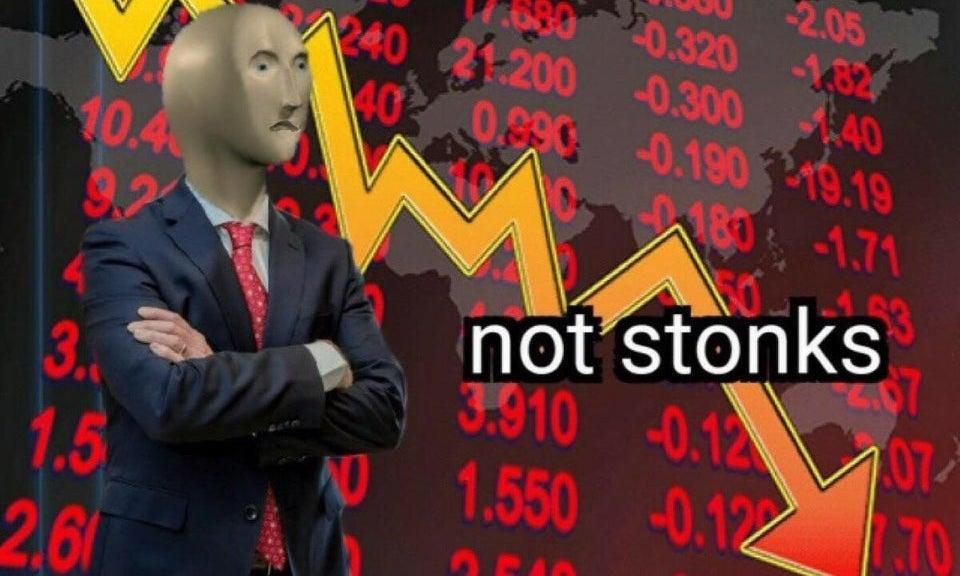

Последняя попытка - предел - 99

In [661]:
X_without_corr, corr_columns_list = search_corr(X, 0.99)
print("Columns are needed to deleted", corr_columns_list)
model5, X5 = new_model(X_without_corr, Y, ['_'], 5)

del_list5 = del_list + corr_columns_list
new_predict(model5, df_test, del_list5, 5)

Column =  TotalAssets
Connections: 
NetWorth    0.993819
Name: TotalAssets, dtype: float64

Columns are needed to deleted ['NetWorth']
Model 5 =
Train RMSE = 4.3893
Test RMSE = 4.3149

['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MSE Model 5 = 18.96

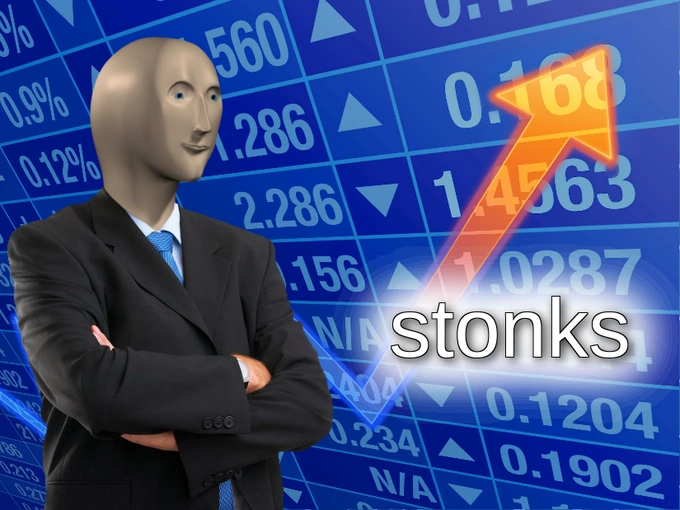  

Оставляем удаление только "NetWorth". А теперь попробуем удалить столбцы со слабой корреляцией с таргет-переменной

In [662]:
correlations = X.corrwith(Y).abs().sort_values(ascending=False)
correlations[correlations<0.1]

,0
LoanAmount,0.079041
LengthOfCreditHistory,0.055507
PreviousLoanDefaults,0.055248
CreditCardUtilizationRate,0.053080
EmploymentStatus_Employed,0.048902
Experience,0.044865
Age,0.042744
EmploymentStatus_Unemployed,0.038099
EducationLevel_High School,0.033626
EmploymentStatus_Self-Employed,0.031396


In [663]:
X = X5
del_list = del_list5
print(del_list)

correlations = X.corrwith(Y).abs().sort_values(ascending=False)
lst2 = correlations[correlations<0.002]
lst2 = list(lst2.index)
print(lst2)

model8, X8 = new_model(X, Y, lst2+del_list, 8)

['ApplicationDate', 'NetWorth']
['MaritalStatus_Single', 'NumberOfOpenCreditLines']
Model 8 =
Train RMSE = 4.3897
Test RMSE = 4.3152



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Проверим наши столбцы на выбросы. Будем использовать меру IQR. Напишем функцию, которая будет выводить информацию о выбросах в каждром столбце и их значения, если таковые имеются. На данном этапе ничего не удаляем/заменяем, этим займемся потом

LB =  -412500.0 Ub =  727500.0
count      9332.000000
mean     131643.614231
std      116023.044931
min       15000.000000
25%       21030.500000
50%       88961.500000
75%      257499.750000
max      748508.000000
Name: AnnualIncome, dtype: float64
Series([], Name: AnnualIncome, dtype: float64)
655     748508.0
1528    743813.0
2856    730234.0
5463    747753.0
7388    734061.0
7512    736004.0
Name: AnnualIncome, dtype: float64

LB =  -51694.774999999994 Ub =  111546.625
count      9332.000000
mean      29806.541470
std       27314.548547
min        1063.000000
25%       12632.750000
50%       21814.000000
75%       37173.500000
max      418997.000000
Name: LoanAmount, dtype: float64
Series([], Name: LoanAmount, dtype: float64)
71      129587.0
82      126585.0
248     183473.0
270     123877.0
285     139590.0
          ...   
9820    146187.0
9832    168632.0
9837    116997.0
9902    117129.0
9950    144729.0
Name: LoanAmount, Length: 165, dtype: float64

LB =  -939.0499999999984 U

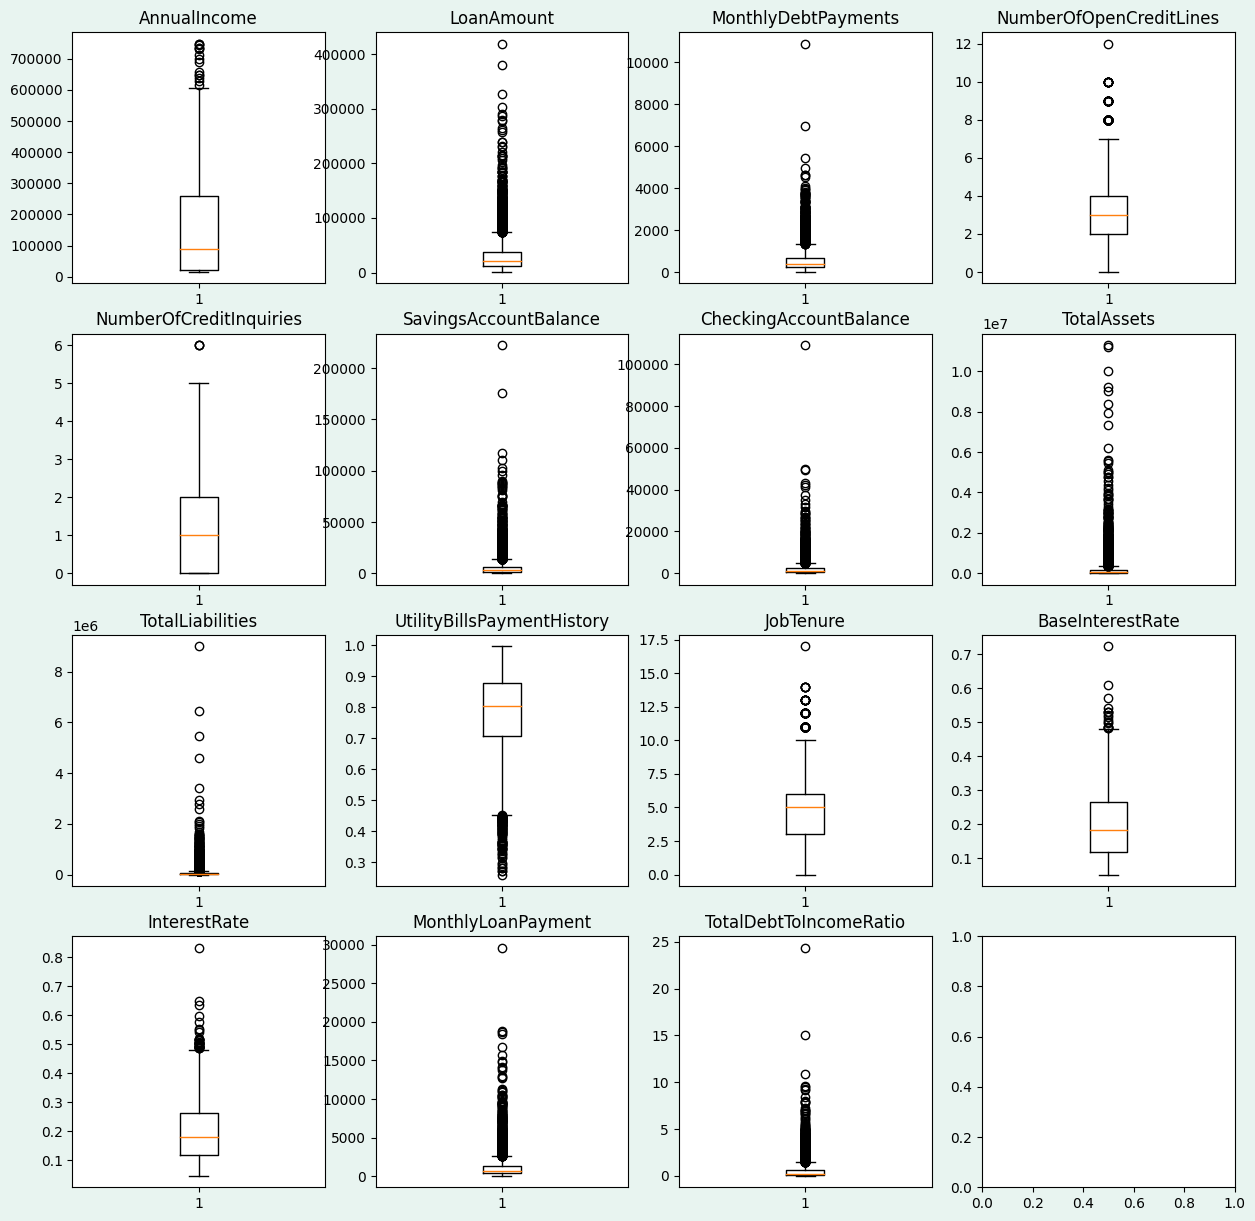

In [664]:
def check_outliers(df, score):
    outlierss_columns = []
    new_df = df.copy()
    for _ in df:
        if df[_].min() ==0 and df[_].max() ==1:
            continue
        q1 = df[_].quantile(score)
        q2 = df[_].quantile(1-score)
        iqr = q2 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q2 + (1.5 * iqr)

        if len(list(df[(df[_] <lower_bound)][_])) > 0 or len(list(df[(df[_] >upper_bound)][_])) >0:
            print("LB = ", lower_bound, "Ub = ", upper_bound)
            print(df[_].describe())
            print(df[(df[_] <lower_bound)][_])
            print(df[(df[_] >upper_bound)][_])
            print()
            outlierss_columns.append(_)
            # outlieners_list = df[(df[_] > df[_].quantile(0.995))][_]
            tmp_df = df[_].drop(index =df[_].index[df[_] > df[_].quantile(0.95)].tolist())
            # new_df[df[_] > df[_].quantile(0.995)][_] = tmp_df.mean()
            # print(tmp_df.mean())
            new_df.loc[df.index[df[_] > df[_].quantile(0.95)].tolist(), _] = tmp_df.mean()
            # print(new_df[_].describe())
            # outlieners_list = df[(df[_] > df[_].quantile(0.995))][_]

            # print(outlieners_list)
            # break
    return new_df,outlierss_columns


X_new, outliers_column_list =  check_outliers(X, 0.15)
# print(X_new['AnnualIncome'].describe())
#Show boxplots
plot_cnt = int((len(outliers_column_list)+1)**0.5)
print(len(outliers_column_list))
figure, axes = plt.subplots(plot_cnt, plot_cnt, figsize=(15, 15), facecolor='#e8f4f0')
for i in range(plot_cnt):
    for j in range(plot_cnt):
        # print("i=", i, " | j=", j)
        if i*plot_cnt+j >= len(outliers_column_list):
          break
        axes[i,j].boxplot(x=X[outliers_column_list[i*plot_cnt+j]])
        axes[i,j].set_title(outliers_column_list[i*plot_cnt+j])


In [665]:
model9, X9 = new_model(X_new, Y, del_list, 9)
new_predict(model9, df_test, del_list, 9)

# X = X_new

Model 9 =
Train RMSE = 4.1840
Test RMSE = 4.2655

['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Новый столбец "Years cnt" выглядит не очень, но пока оставим его и попробуем обучить модель в текущем виде.

На обучении результаты хорошие, в тесте 33... Не пойдет

Попробуем расммотреть распределение данных в наших столбцах. Попробуем стандартизировать наши данные без удаления выбросов

count      9332.000000
mean     131568.862087
std      115662.213104
min       15000.000000
25%       21030.500000
50%       88961.500000
75%      257499.750000
max      650000.000000
Name: AnnualIncome, dtype: float64


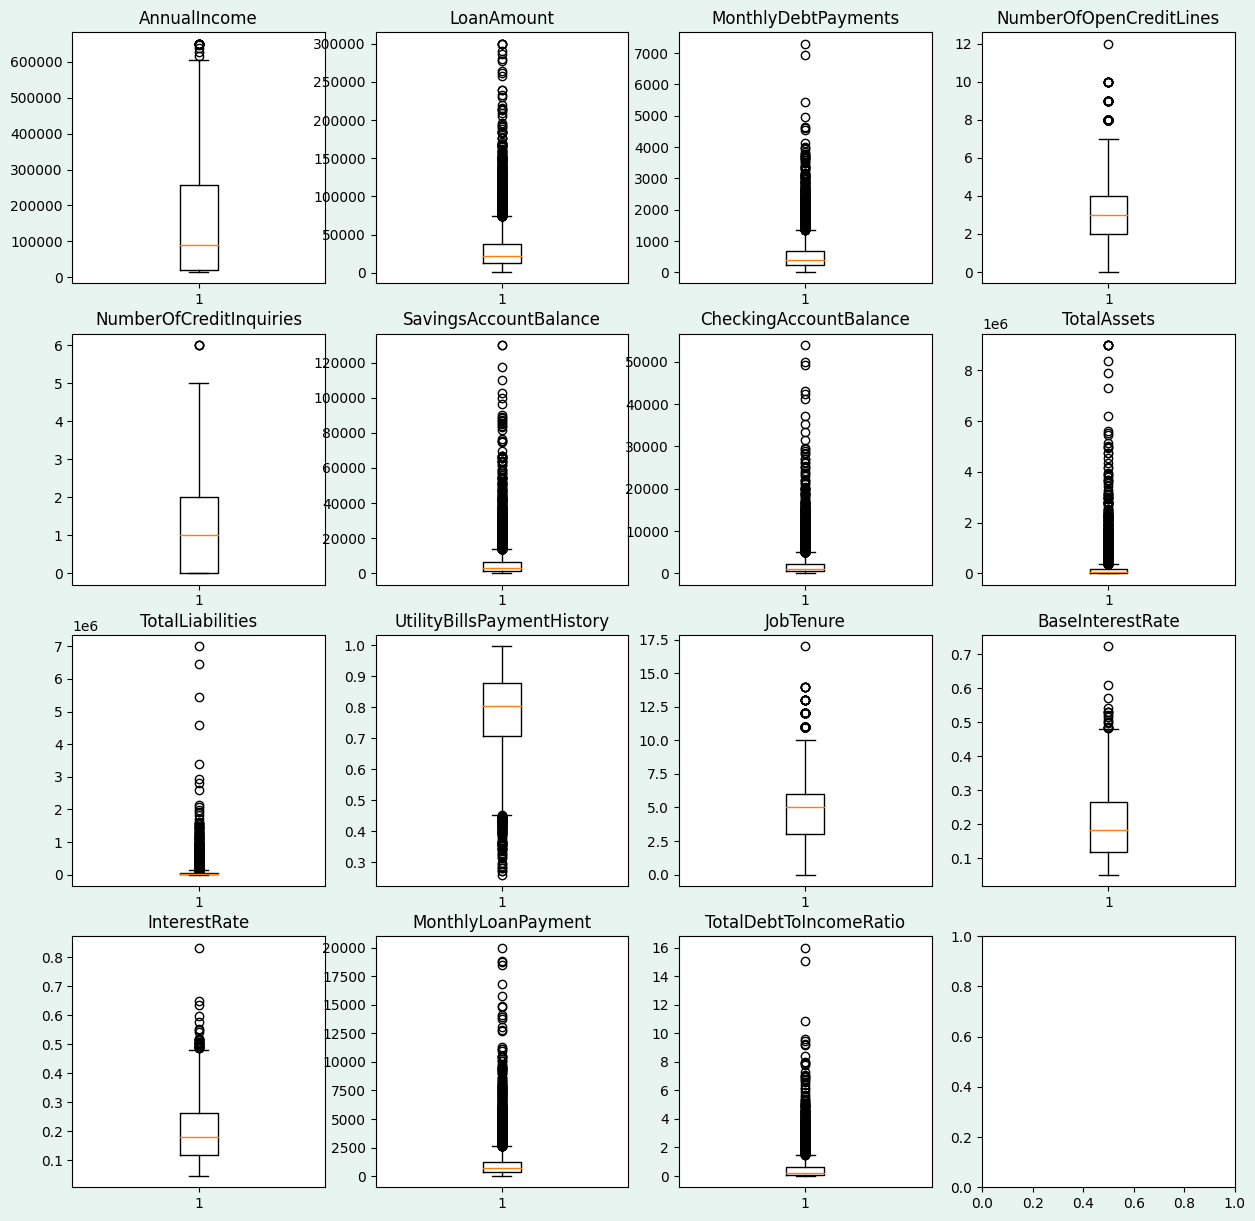

In [666]:
# AnnualIncome LoanAmount MonthlyDebtPayments SavingsAccountBalance CheckingAccountBalance TotalAssets TotalLiabilities MonthlyLoanPayment TotalDebtToIncomeRatio

def change_val(df, columns, values):
    new_df = df.copy()
    for col, value in zip(columns, values):
        new_df.loc[new_df[col] > value, col] = value
    return new_df

columns_list = ['AnnualIncome', 'LoanAmount', 'MonthlyDebtPayments', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio']
val_list = [650000, 300000, 7300, 130000, 54000, 9000000, 7000000, 20000, 16]
X_2= change_val(X, columns_list, val_list)
X = X_2
print(X['AnnualIncome'].describe())
# print(X[X['AnnualIncome']> 650000]['AnnualIncome']
# new_df.loc[df.index[df[_] > df[_].quantile(0.95)].tolist(), _] = tmp_df.mean()

# print(X['TotalAssets'].max())

figure, axes = plt.subplots(plot_cnt, plot_cnt, figsize=(15, 15), facecolor='#e8f4f0')
for i in range(plot_cnt):
    for j in range(plot_cnt):
        # print("i=", i, " | j=", j)
        if i*plot_cnt+j >= len(outliers_column_list):
          break
        axes[i,j].boxplot(x=X[outliers_column_list[i*plot_cnt+j]])
        axes[i,j].set_title(outliers_column_list[i*plot_cnt+j])


Попробовали почистить данные ручками, посмотрим метрики

In [667]:
model10, X10 = new_model(X, Y, del_list, 10)
new_predict(model10, df_test, del_list, 10)

Model 10 =
Train RMSE = 4.3772
Test RMSE = 4.3060

['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


В системе метрики стали лчуше на тысячные. Оставляем

### 3. Model Fitting

Проверим, какие признаки оказали наиболее сильное влияние

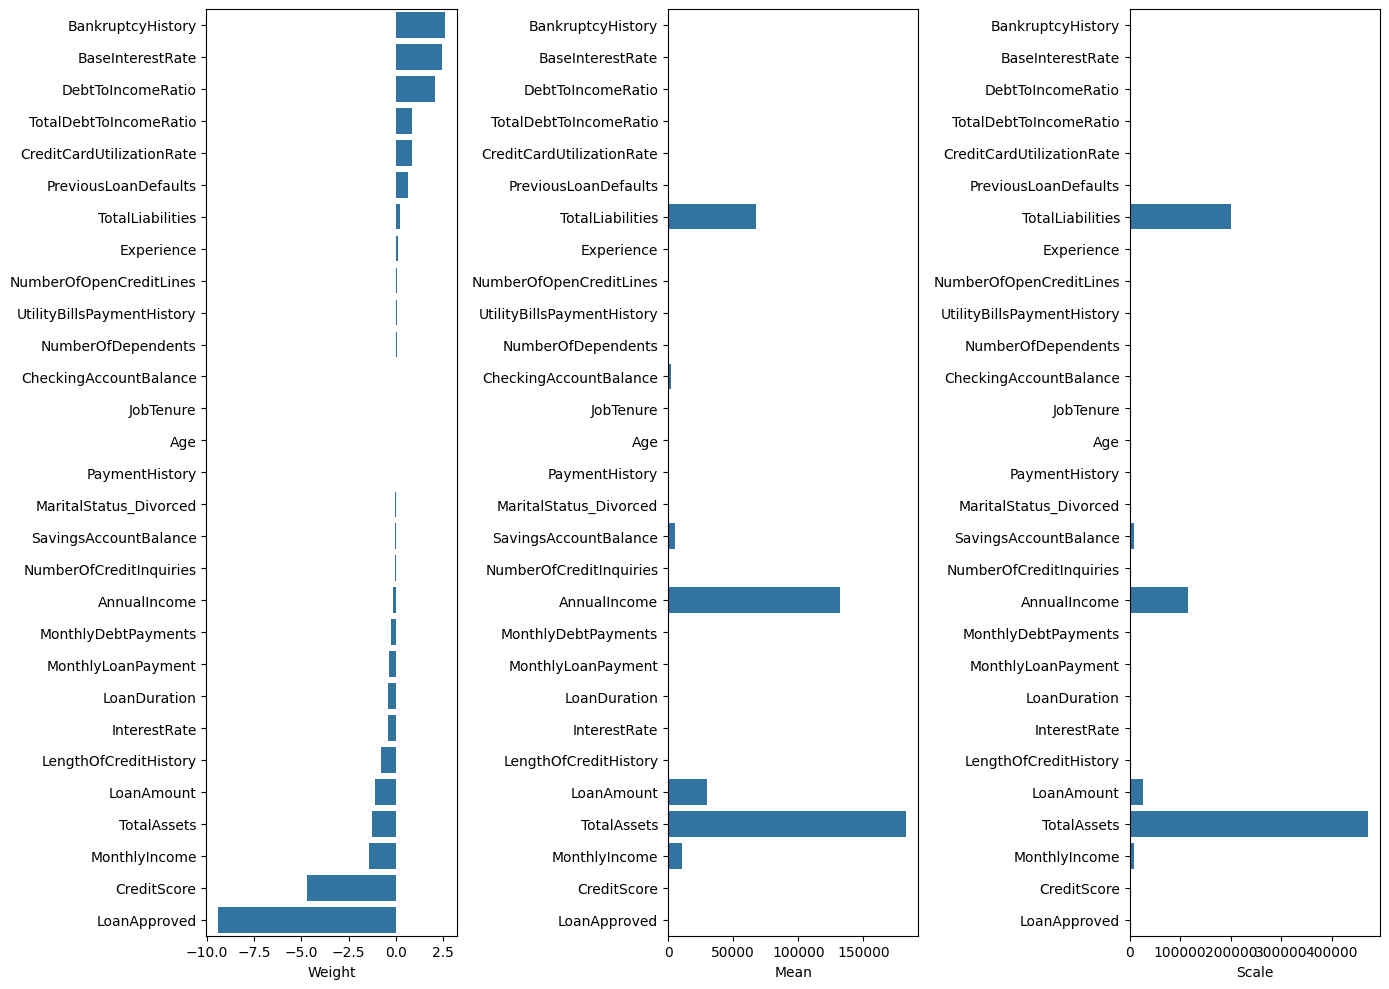

In [668]:
def show_weights(df, weights, means, scales):
    df=df.columns
    fig, axs = plt.subplots(figsize=(14, 10), ncols=3)
    sorted_weights = sorted(zip(weights, df, means, scales), reverse=True)
    weights, df, means, scales = zip(*sorted_weights)
    df = list(df)

    sns.barplot(y=df, x=list(weights), ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=df, x=list(means), ax=axs[1])
    axs[1].set_xlabel("Mean")
    sns.barplot(y=df, x=list(scales), ax=axs[2])
    axs[2].set_xlabel("Scale")
    plt.tight_layout()

show_weights(X, model.coef_, X_train.mean(), X_train.std())


In [672]:
# for _ in del_list:
#   if _ in X:
#     X = X.drop(columns = _)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

# print(list(X_train.columns).remove(ohe_col))
l_numeric = [x for x in list(X_train.columns) if x not in ohe_col]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[l_numeric])
X_test_scaled = scaler.transform(X_test[l_numeric])

model11 = Ridge()
model11.fit(X_train_scaled, Y_train)

y_test = model11.predict(X_test_scaled)
y_train = model11.predict(X_train_scaled)

print("Train RMSE = %.4f" % mean_squared_error(Y_train, y_train, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(Y_test, y_test, squared=False))


model12 = LinearRegression()
model12.fit(X_train_scaled, Y_train)

y_test = model12.predict(X_test_scaled)
y_train = model12.predict(X_train_scaled)

print("Train RMSE = %.4f" % mean_squared_error(Y_train, y_train, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(Y_test, y_test, squared=False))

# def new_model(X, Y, del_columns_list, idx):
#     model = LinearRegression()
#     for _ in del_columns_list:
#       if _ in X:
#         X = X.drop(columns = _)

#     #Разобъем данные на тестовую и тренировочные выборки
#     X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

#     model.fit(X_train.values, Y_train.values)

#     y_test = model.predict(X_test.values)
#     y_train = model.predict(X_train.values)

#     print("Model",idx, "=")
#     print("Train RMSE = %.4f" % mean_squared_error(Y_train, y_train, squared=False))
#     print("Test RMSE = %.4f" % mean_squared_error(Y_test, y_test, squared=False))
#     print()
#     return model, X


Train RMSE = 4.4880
Test RMSE = 4.3974
Train RMSE = 4.4880
Test RMSE = 4.3974


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-337-e5f29c6336ab>:50: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your c

Test RMSE = 4.3652
Train RMSE = 4.2906


<Axes: xlabel='LoanAmount', ylabel='Density'>

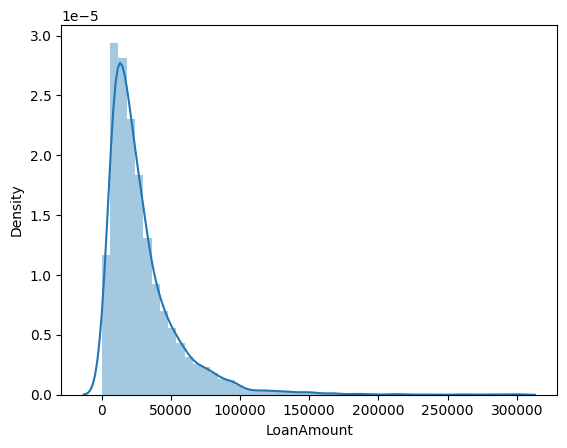

In [337]:
def discrete(df, columns):
    t = 10
    df_depth = df.shape[0]
    for _ in columns:
        min_val = df[_].min()
        max_val = df[_].max()
        # print(min_val)
        k = int((max_val - min_val)/t) +1
        val = min_val+k
        name = _ +"_"+str(0)
        df[name] = pd.Series(df[_]<= val, dtype=int)
        for i in range(t):
          val+=k
          name = _ +"_"+str(i+1)
          df[name] = pd.Series((df[_]<= val) & (df[_]<=val), dtype=int)
          # df[(df[_]>val-k ) & (df[_]<=val)][_]
          # df[name] = df[name].fillna(0)
          print(val)
    df = df.drop(columns = columns)
    return df


def test_preparing(df, del_columns):
    new_df, tmpp = ohe(df) #дискретизируем признаки
    cur_year = datetime.now().year
    new_df['Years_cnt'] =pd.Series(cur_year - df['ApplicationDate'].dt.year, dtype=int)
    new_df = new_df.drop(columns= 'ApplicationDate')
    for _ in del_columns:
      if _ in df:
        new_df = new_df.drop(columns = _) # Удаление указанных столбцов
    # new_df = discrete(new_df, ['Age'])
    return new_df


# X_tmp = discrete(X, ['Age'])
# print(X_tmp['Age_7'])
# X = X_tmp


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

model = LinearRegression()
model.fit(X_train.values, y_train.values)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

sns.distplot(X["LoanAmount"])

#Old
# Test RMSE = 4.3149
# Train RMSE = 4.3893

Проверим Зависимость от признаков таргета

*   Новый пункт
*   Новый пункт



In [338]:

cnt_par = int((X.shape[1])**0.5)
list_par = list(X.columns)
# print(list_par)
# print(X.shape)
# print(cnt_par)


# figure, axes = plt.subplots(cnt_par, cnt_par, figsize=(20, 20), facecolor='#e8f4f0')
# for i in range(cnt_par):
#     for j in range(cnt_par):
#         # print("i=", i, " | j=", j)
#         if i*cnt_par+j >= X.shape[1]:
#           break
#         sns.distplot(ax=axes[i,j], x=list_par[i*plot_cnt+j])
#         # axes[i,j].distplot(X, x=list_par[i*plot_cnt+j], y=Y)
#         axes[i,j].set_title(list_par[i*plot_cnt+j])


Проверим, какие признаки оказали наиболее сильно влияние

---



In [340]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)



# X_test_20 = test_preparing(df_test, "_")
# Terget_predict=pd.DataFrame(X_test_20['ID'])
# X_test_20=X_test_20.drop(columns=['ID', 'NetWorth'])
# X_test_20 = X_test_20.astype(float)

# Terget_predict=pd.DataFrame(X_test_20['ID'])
X_test_scaled = scaler.transform(X_test)

model = Ridge()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

# predict  = model.predict(X_test)

# df_predict = pd.DataFrame(Terget_predict)
# Terget_predict.to_csv("/content/drive/MyDrive/Учеба/ PyColab/Lineral_Regression/target.csv", index=False)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 4.4677
Train RMSE = 4.3750


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### 3.2

Y

In [341]:
model_1 = LinearRegression()
model_2 = LinearRegression()

threshold = 0.33
mask = (X_train.DebtToIncomeRatio <= threshold)
X_train_1 = X_train[mask]
y_train_1 = y_train[mask]
X_train_2 = X_train[~mask]
y_train_2 = y_train[~mask]

model_1.fit(X_train_1.values, y_train_1.values)
model_2.fit(X_train_2.values, y_train_2.values)

X_test_10 = test_preparing(df_test, "_")
# X_final_test.columns
Terget_predict=pd.DataFrame(X_test_10['ID'])
X_test_10=X_test_10.drop(columns=['ID', 'NetWorth'])
X_test_10 = X_test_10.astype(float)


y_pred_1 = model_1.predict(X_test_10)
y_pred_2 = model_2.predict(X_test_10)
mask_test = (X_test_10.DebtToIncomeRatio <= threshold)
Terget_predict['RiskScore']= y_pred_1.copy()
Terget_predict[~mask_test]['RiskScore'] = y_pred_2[~mask_test]



print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
pd.DataFrame(Terget_predict).to_csv("/content/drive/MyDrive/Учеба/ PyColab/Lineral_Regression/target_11.csv", index=False)
#Test RMSE = 4.2856

['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


ValueError: X has 50 features, but LinearRegression is expecting 35 features as input.

### 4. Test-Target Predict

In [ ]:
# Columns are needed to deleted ['Experience', 'MonthlyIncome', 'LoanApproved', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'NetWorth', 'EmploymentStatus_Self-Employed']


# X_final_test = test_preparing(df_test, corr_columns_list)
X_final_test = test_preparing(df_test, "_")
X_final_test.columns
Terget_predict=pd.DataFrame(X_final_test['ID'])
X_final_test=X_final_test.drop(columns=['ID', 'NetWorth'])
X_final_test = X_final_test.astype(float)

# X_final_test = (X_final_test - means)/stds
Terget_predict['RiskScore']  = model.predict(X_final_test)

# df_predict = pd.DataFrame(Terget_predict)
Terget_predict.to_csv("/content/drive/MyDrive/Учеба/ PyColab/Lineral_Regression/target.csv", index=False)

# print(df_predict)
# print(Terget_predict)
# # print(X)

# X_final_test['JobTenure'].describe()